# A journey into Convolutional Neural Network visualisation 

There is one famous urban legend about computer vision. Around the 80s, the US military wanted to use neural networks to automatically detect camouflaged enemy tanks. They took a number of pictures of trees without tanks and then pictures with the same trees with tanks behind them.
The results were impressive. So impressive that the army wanted to be sure the net had correctly generalized. They took new pictures of woods with and without tanks and they showed them again to the network. This time, the model performed terribly, it was not able to discriminate between pictures tanks behind woods and just trees. It turned out, that all the pictures with of plain woods were taken on a cloudy day while the ones with tanks on a sunny day! In reality, the network lean to recognize the weather, not the enemy tanks.

With this article we are going to see different techiniques to *understand* what it is going on inside a Convolutional Neural Network to making the same mistake made, ipotetically, by the US army.

The structure is the following:
 - Introduction of the most used techniques
 - Visualisation of common neural networks
 - Visualisation of uncommon neural networks
 - Conclusion
 
We are going to use [Pytorch](https://pytorch.org/) and not Tensorflow since Pytorch is  better framework under all aspects, providing good practice a well written documentation, two main features the Google is missing. All the code can be found [here](https://github.com/FrancescoSaverioZuppichini/A-journey-into-Convolutional-Neural-Network-visualization-), the visualisations are taken from an other [repo](https://github.com/FrancescoSaverioZuppichini/cnn-visualisations). 

We are going to analise two differnt sets of model, classic and unusual. The classic models are the normal backbones used in computer vision:
 - alexnet
 - vgg16
 - resnet (with and without bottleneck)
 - SENet

The second sets are models trained on a very specific missions:
 - U-net trained for salt classification
 - A CNN trained for a robotic task
 
Our goal is to use visualisations techniques to highline and discover differnt aspect of this models. For example, which features is used to understand that a image contains a cat? 

# Classic models
Let's start our journey by selecting some images to be used as inputs. We are first going to fire up `alexnet` and introducing each visualisation techniques. After than we are going to explore the difference between the *classic* models

In [1]:
from torchvision.models import alexnet, resnet34, vgg16

model = alexnet(pretrained=True)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

Now we need some inputs

In [2]:
%matplotlib notebook

In [3]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import torch 

from PIL import Image

plt.rcParams["figure.figsize"]=7,7


In [4]:
def tensor2img(tensor, ax=plt):
    tensor = tensor.squeeze()
    if len(tensor.shape) > 2: tensor = tensor.permute(1, 2, 0)
    img = tensor.detach().cpu().numpy()
    return img

In [52]:
def subplot(images, parse=lambda x: x, title='', *args, **kwargs):
    fig, ax = plt.subplots(*args, **kwargs)
    fig.suptitle(title)
    i = 0
    try:
        for row in ax:
            try:
                for col in row:
                    col.imshow(parse(images[i]))
                    col.axis('off')
                    col.set_aspect('equal')
                    i += 1
            except TypeError:
                row.imshow(parse(images[i]))
                row.axis('off')
                row.set_aspect('equal')
                i += 1
            except IndexError:
                break
    except:
        ax.imshow(parse(images[i]))
        ax.axis('off')
        ax.set_aspect('equal')
    plt.subplots_adjust(wspace=0, hspace=0)


<IPython.core.display.Javascript object>


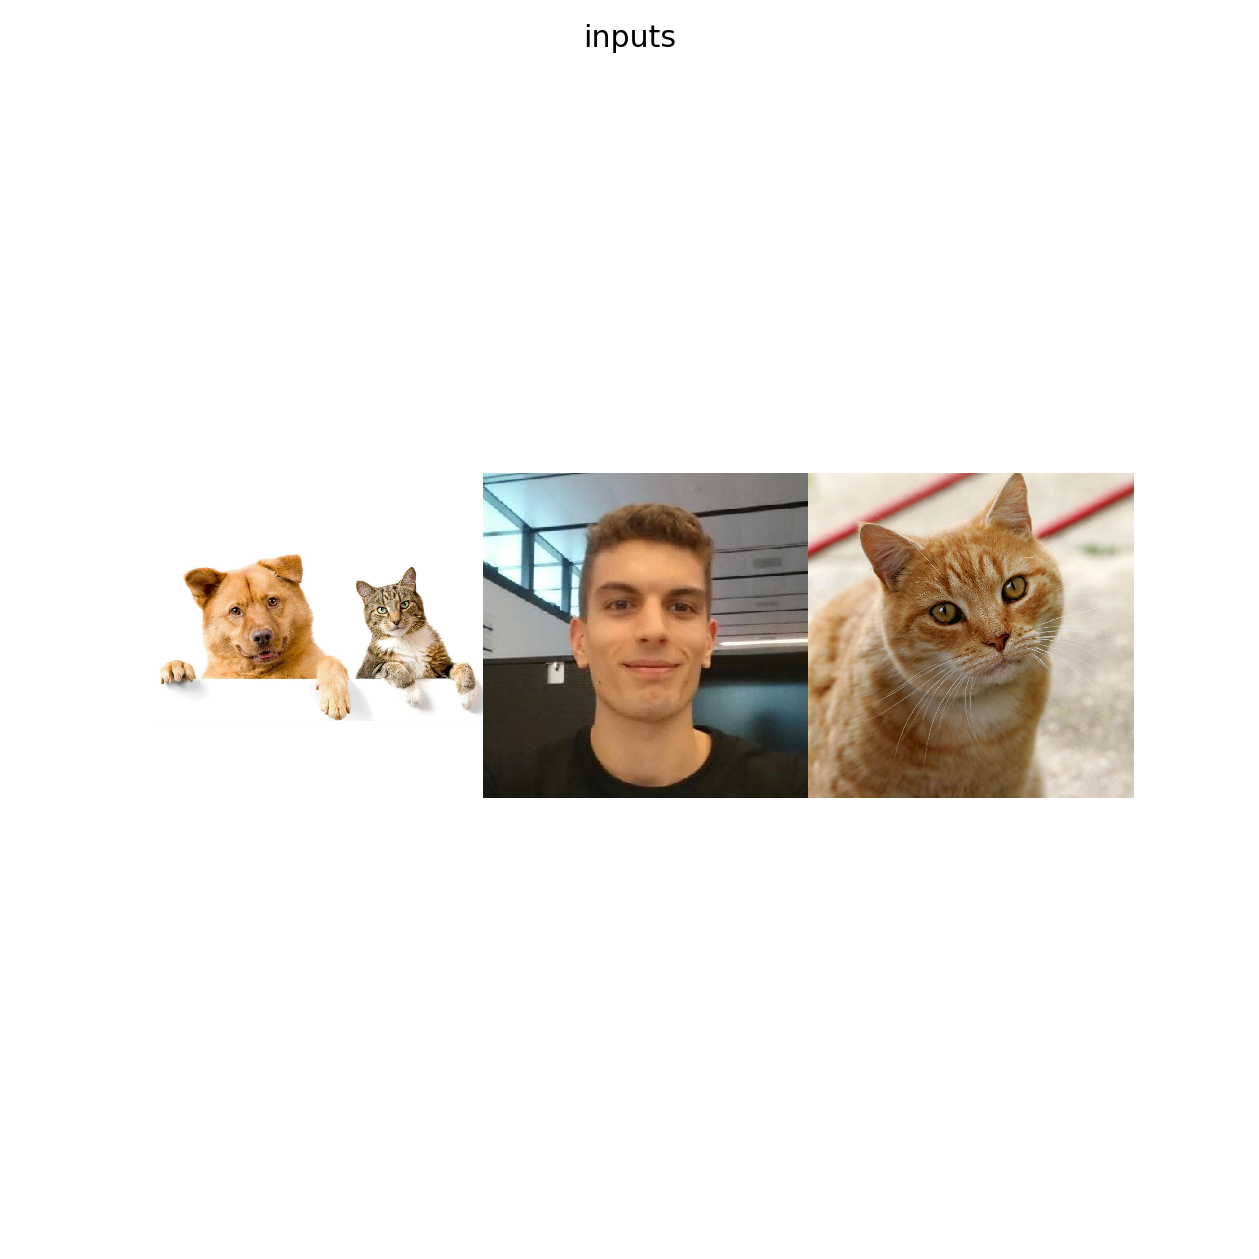

In [53]:
import glob
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

image_paths = glob.glob('./images/*.*')

images = list(map(lambda x: Image.open(x), image_paths))

subplot(images, title='inputs', nrows=1, ncols=3)

plt.show()

In [54]:
from torchvision.transforms import ToTensor, Resize, Compose
from visualisation.core import *
from visualisation.core.utils import image_net_preprocessing

inputs  = [Compose([Resize((224,224)), ToTensor(), image_net_preprocessing])(x).unsqueeze(0) for x in images]  # add 1 dim for batch


# Weights Visualisation
The first straightfoward visualisation is to just plot the weigths of a target Layer. Obsviously, the deeper we go the smaller each the image becomes while the channels number increases. We are going to show each channel as a grey array image. Unfortunately, each Pytorch module can be nested and nested, so to make our code as general as possible we first need to trace each sub-module the input traverse and then store each layer in order

In [55]:
def module2traced(module, inputs):
    handles, modules = [], []
        
    def trace(module, inputs, outputs):
        modules.append(module)
    
    def traverse(module):
        for m in module.children():
            traverse(m)
        is_leaf = len(list(module.children())) == 0
        if is_leaf: handles.append(module.register_forward_hook(trace))
        
    traverse(module)
    
    _ = module(inputs)
    
    [h.remove() for h in handles]
    
    return modules

In [56]:
modules = module2traced(model, inputs[0])

Let's plot the first layer

In [57]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

vis = Weights(model, device)

torch.Size([1, 55, 55])


<IPython.core.display.Javascript object>


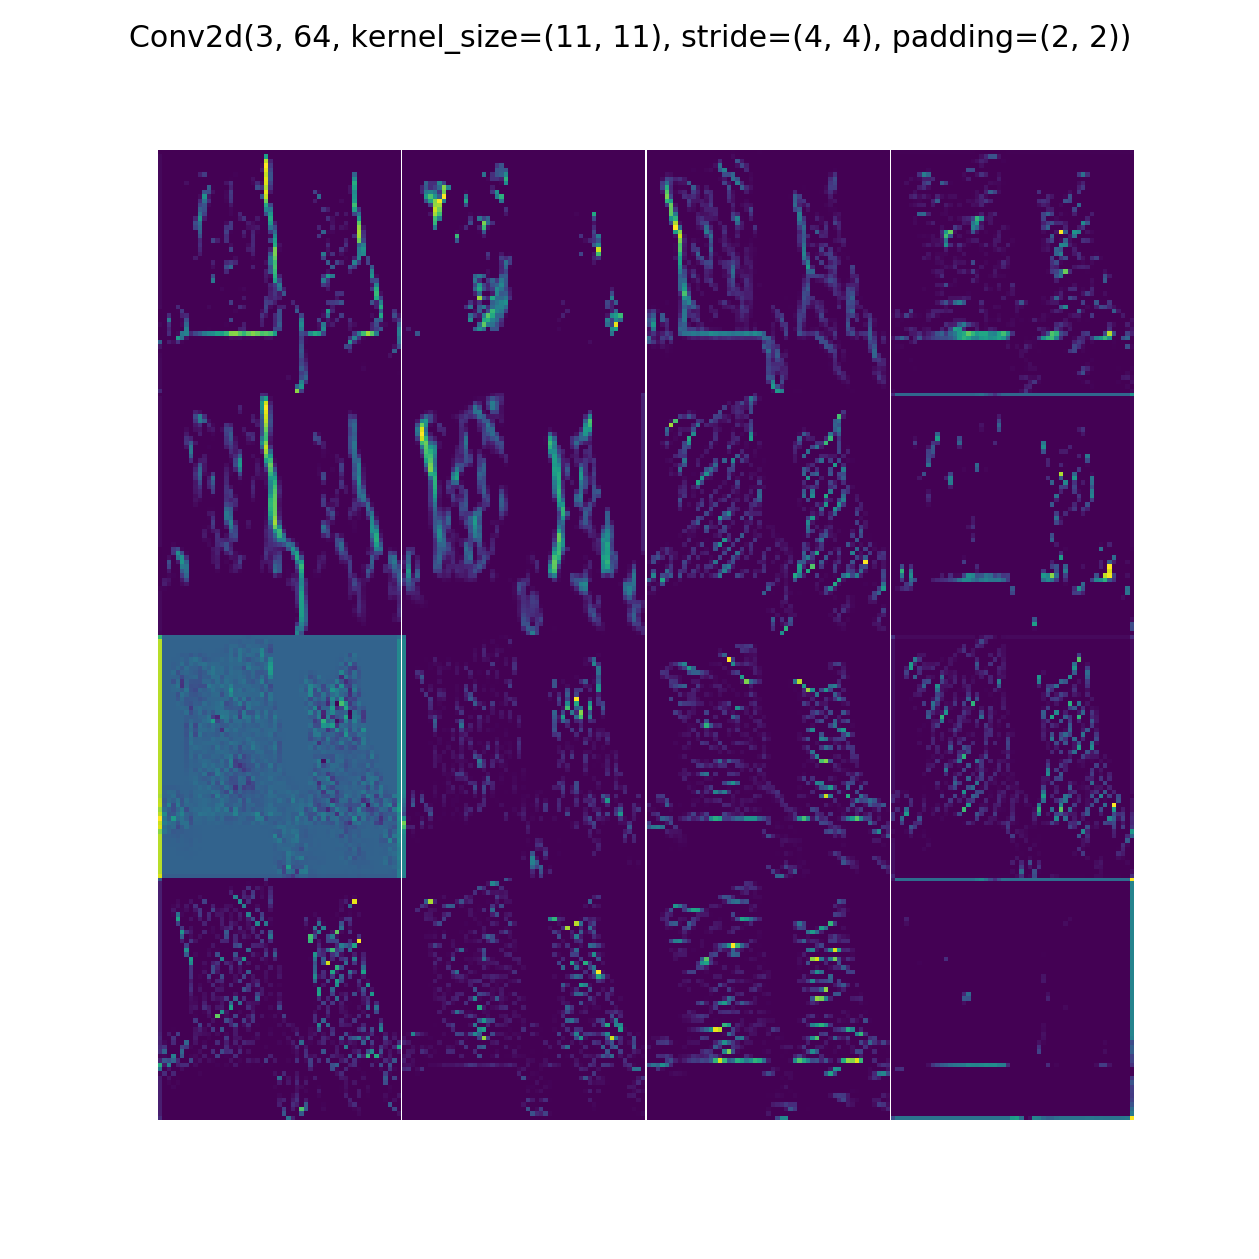

In [59]:
first_layer = modules[0]

def run_vis_plot(vis, x, layer, ncols=1, nrows=1):
    images = vis(x, layer)
    images = images[: nrows*ncols]
    print(images[0].shape)
    subplot(images, tensor2img, title=str(layer), ncols=ncols, nrows=nrows)
    
run_vis_plot(vis, inputs[0], first_layer, ncols=4, nrows=4)

Let's stop for a minute and explain what those images represent. We traced the input trought the computational graph in order to find out all the layers of our models, in this case `alexnet`. Then we used the `Weights` class implemented in `visualisation.core` and we call it by passing the current input, the **cat and dog** image and the **target layer**. As outputs, we get all the current layer's weights as grey images. Then, we plot 16 of them. We can notice that they, in some way, makes sense. Some pixel are brighter in the edges of the images.

Let's try now to plot the first `MaxPool` layer to better see this effect. We should see a dimensional reduction with some higher brighteness pixels in some interesting areas.

torch.Size([1, 27, 27])


<IPython.core.display.Javascript object>


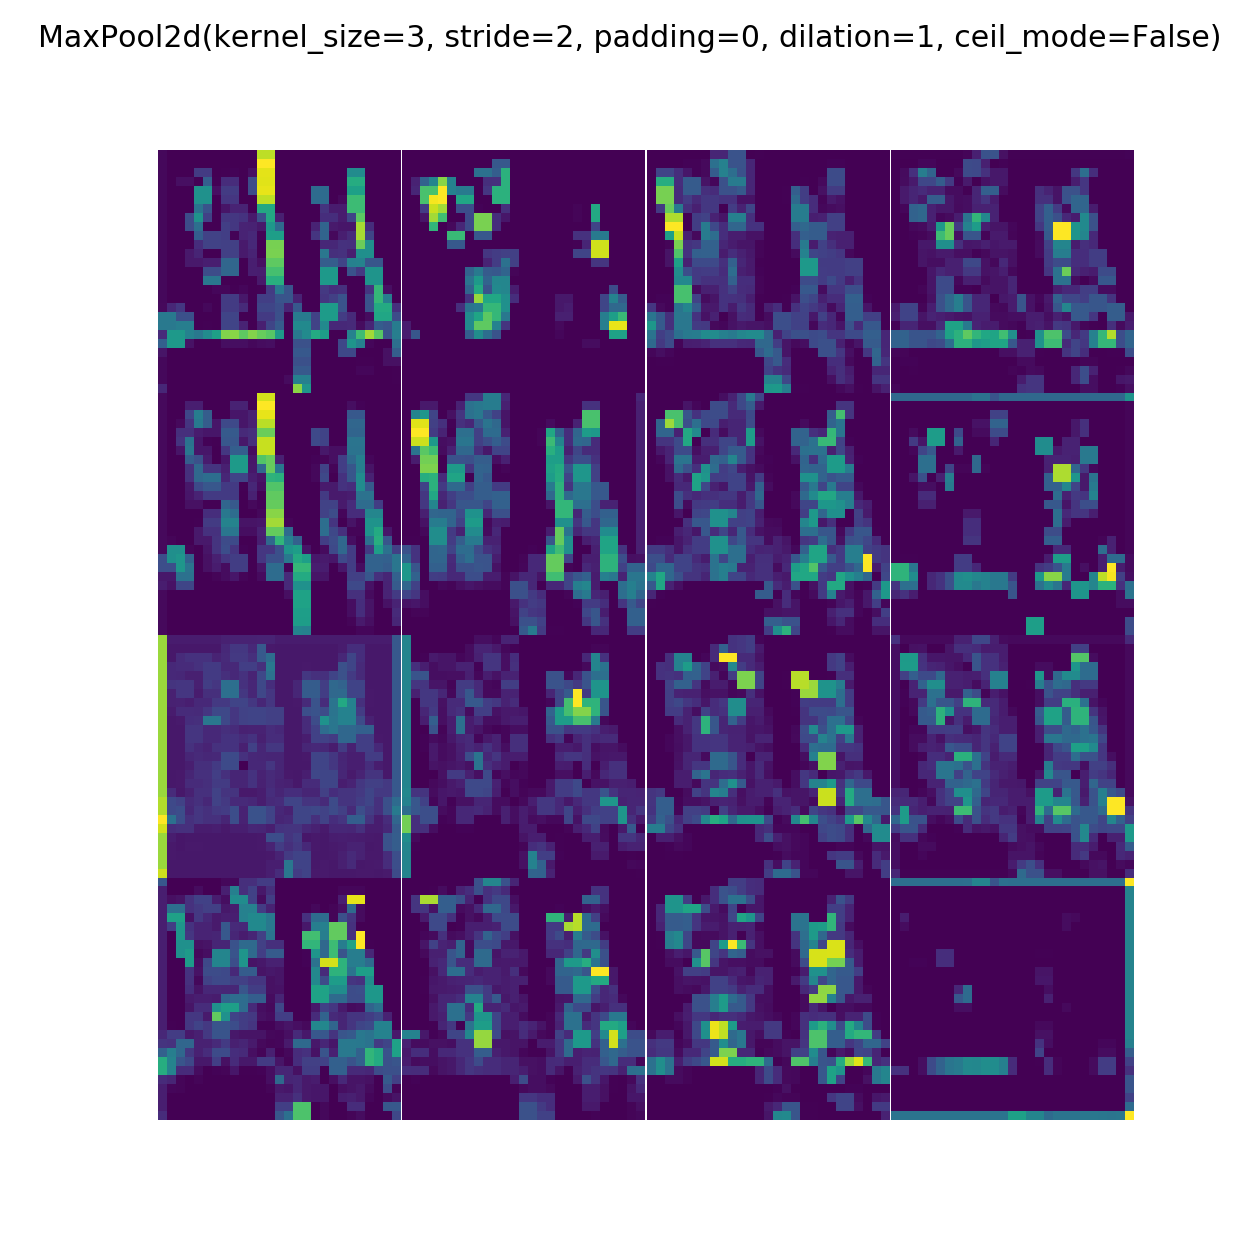

In [60]:
first_relu_layer = modules[2]

run_vis_plot(vis, inputs[0], first_relu_layer, ncols=4, nrows=4)

Let's try with an other input, my face

torch.Size([1, 27, 27])


<IPython.core.display.Javascript object>


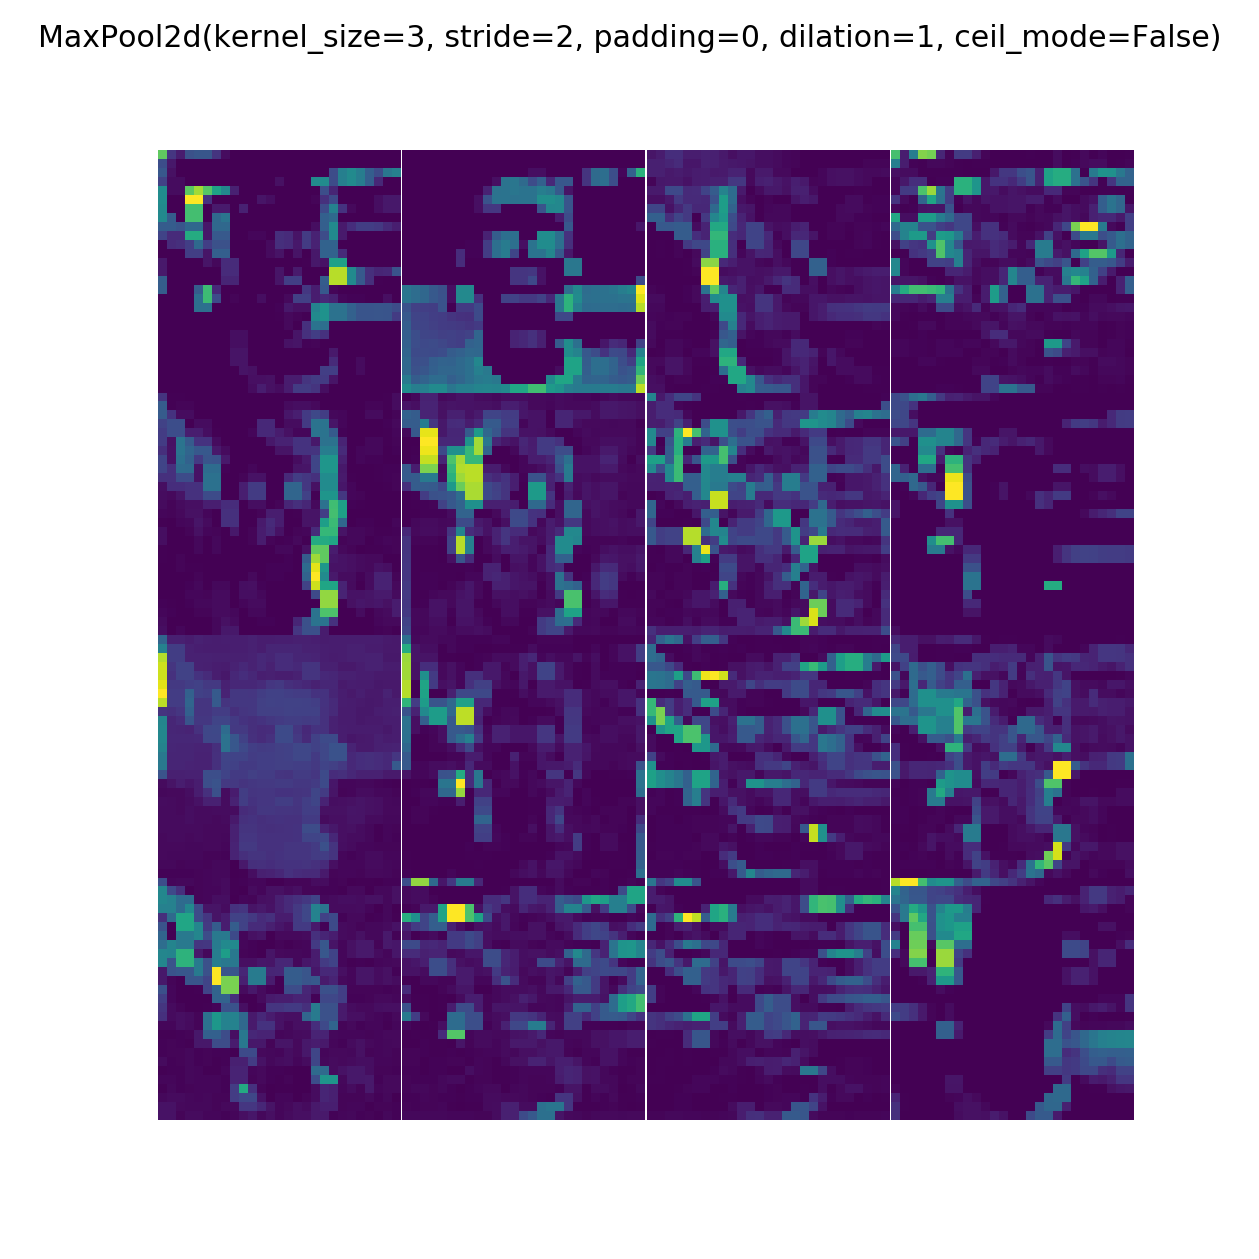

In [61]:
run_vis_plot(vis, inputs[1], first_relu_layer, ncols=4, nrows=4)

Some part of my face are highlighed and they makes sense but it is very hard to understand what the mode is actually doing. The deeper we go the harder becomes to even recognize the input. 

torch.Size([1, 13, 13])


<IPython.core.display.Javascript object>


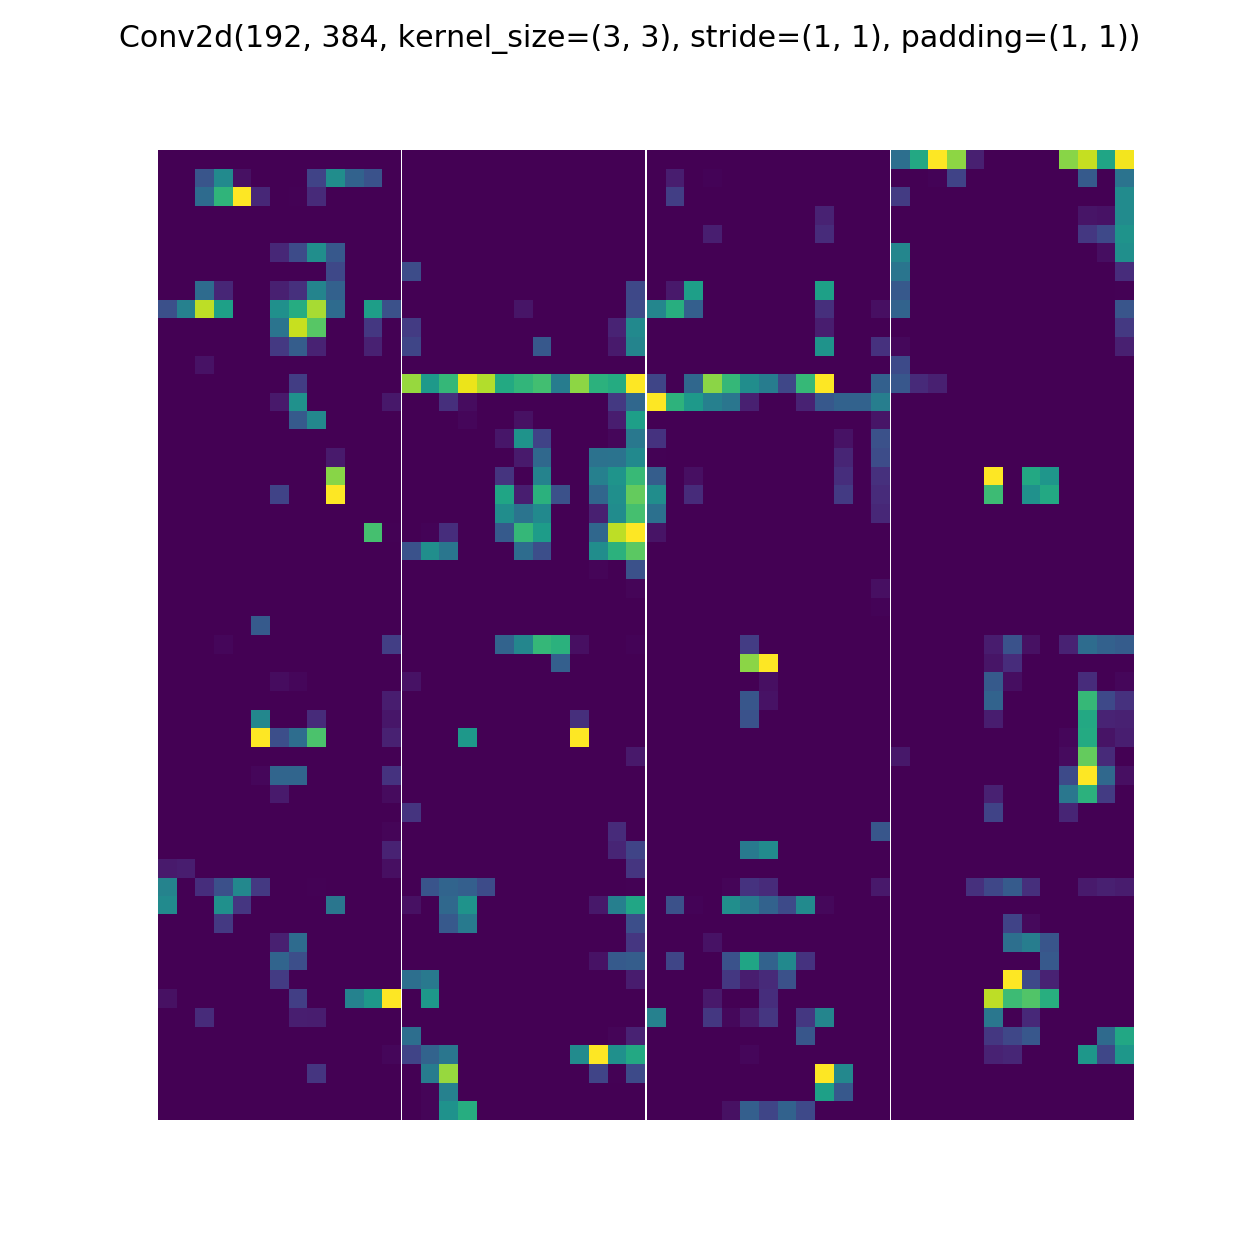

In [62]:
deeper_layer = modules[6]
run_vis_plot(vis, inputs[1], deeper_layer, ncols=4, nrows=4)

In this case, we have no idea of what these images should represent. It can argued that weights visualisation does not carry any useful information about the model, even if this is almost true, there is one main advantages of plotting the weights especially at the first layer. Let's see

torch.Size([1, 55, 55])


<IPython.core.display.Javascript object>


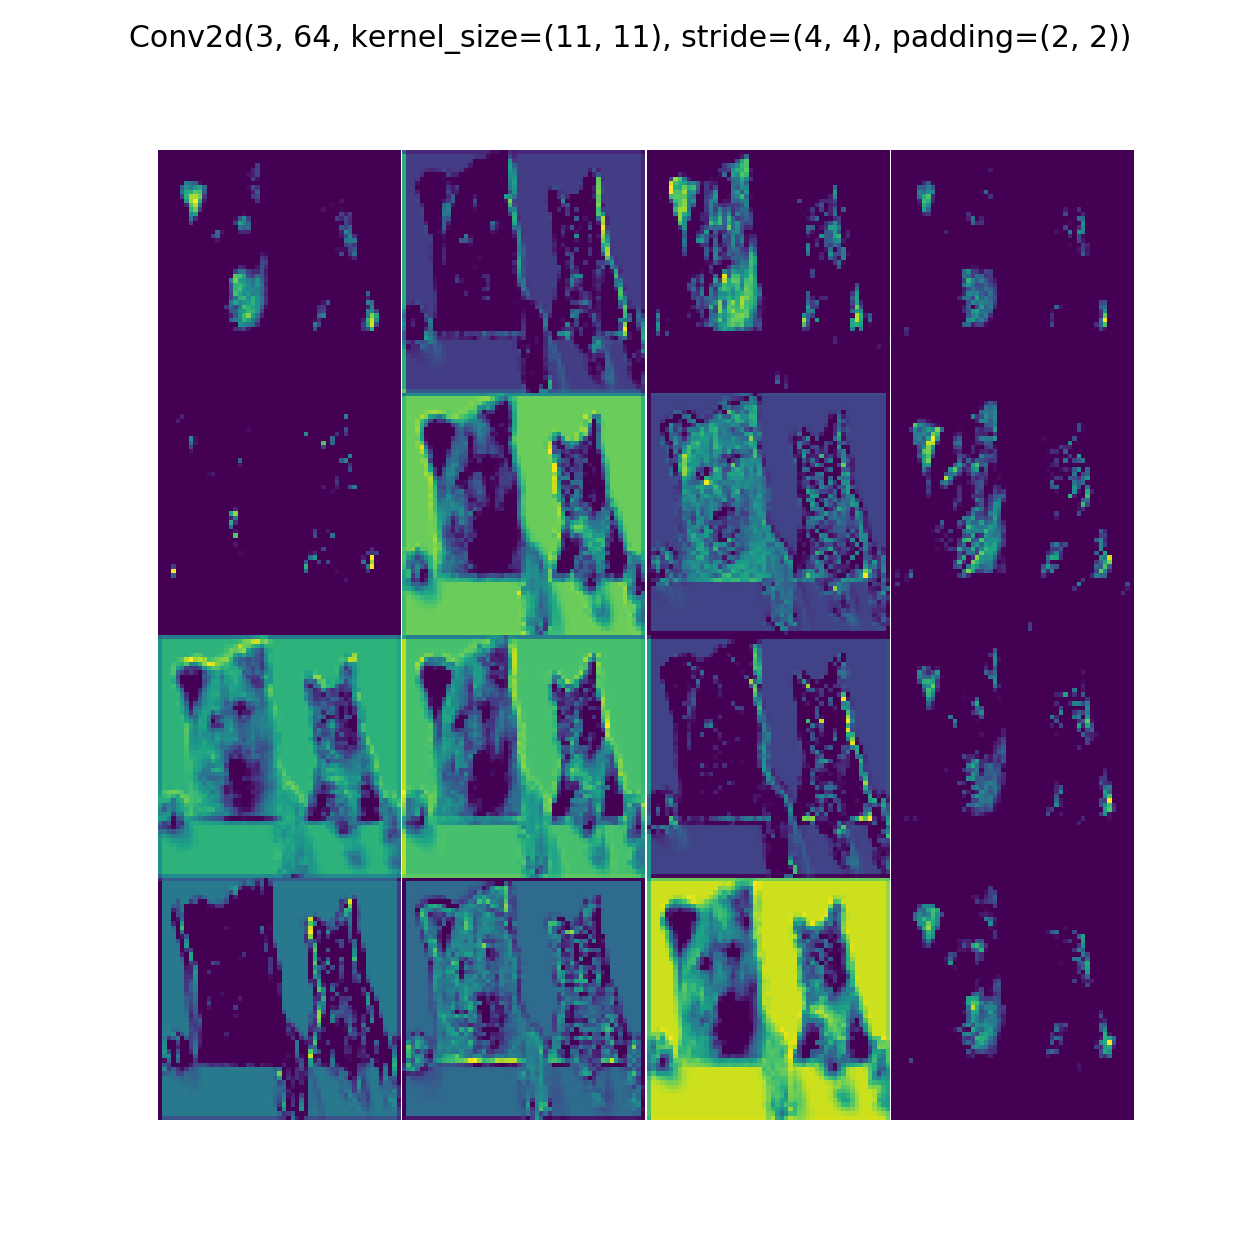

torch.Size([1, 55, 55])


<IPython.core.display.Javascript object>


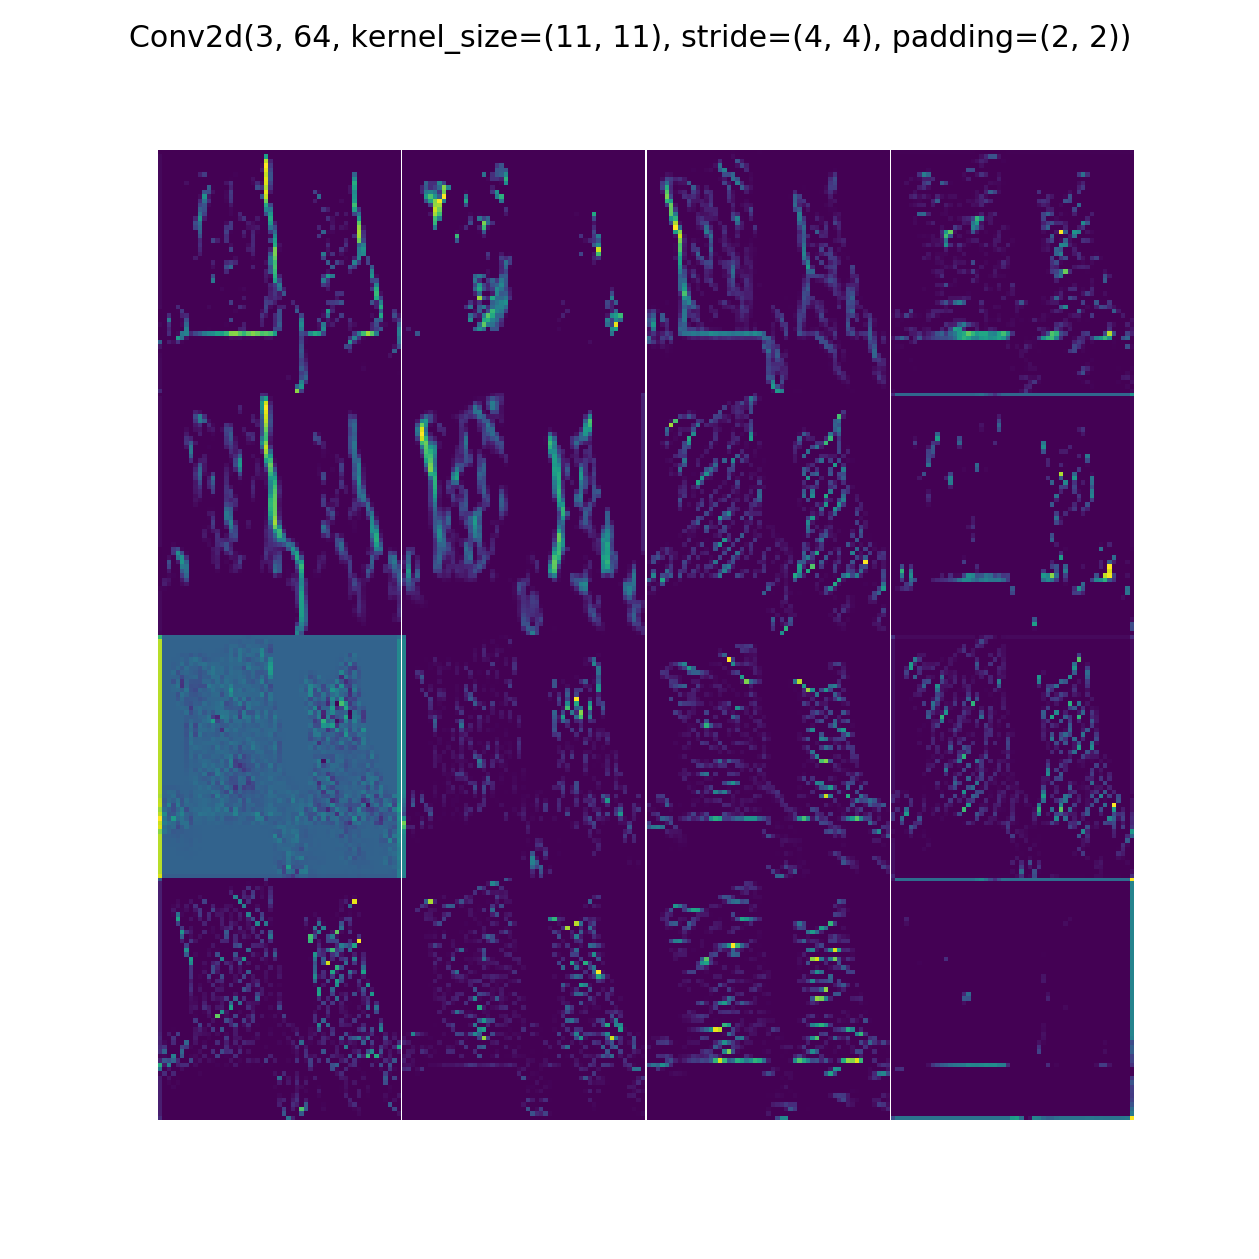

In [63]:
alexnet_not_pretrained = alexnet(pretrained=False)

run_vis_plot(Weights(alexnet_not_pretrained, device), 
             inputs[0], 
             module2traced(alexnet_not_pretrained, inputs[0])[0],
             ncols=4, nrows=4)

alexnet_pretrained = alexnet(pretrained=True)

run_vis_plot(Weights(alexnet_pretrained, device), 
             inputs[0], 
             module2traced(alexnet_pretrained, inputs[0])[0],
             ncols=4, nrows=4)

When a model is poorly trained or not trained at all, the first weights have lots of noise, since they are just random, and they are lots similar to the inputs images than the trained weights. This feature can be usefull to understand on the fly is a model is trained or not. However, expect for this, weights visualisation is not the way to go to understand what the cnn is doing.

## Similarities with other models

We have seen `alexnet`, but are the weights similar across model? 

In [371]:
def run_vis_plot_across_models(modules, input, layer_id, Vis, title, nrows=3, ncols=2, row_wise=True, parse=tensor2img, *args, **kwargs):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
    fig.suptitle(title)       
    for i, row in enumerate(ax):
        try:
            module = next(modules)
            layer = module2traced(module, input)[layer_id]
            vis = Vis(module, device)
            images = vis(input, layer, *args, **kwargs)
            row[0].set_title(module.__class__.__name__)
            for j, col in enumerate(row):
                images = vis(input, layer, *args, **kwargs)
                col.imshow(parse(images[j]))
                col.axis('off')
                col.set_aspect('equal')
        except StopIteration:
            break
        except:
            row.set_title(module.__class__.__name__)
            row.imshow(parse(images[0]))
            row.axis('off')
            row.set_aspect('equal')
    plt.subplots_adjust(wspace=0, hspace=0.5)



<IPython.core.display.Javascript object>


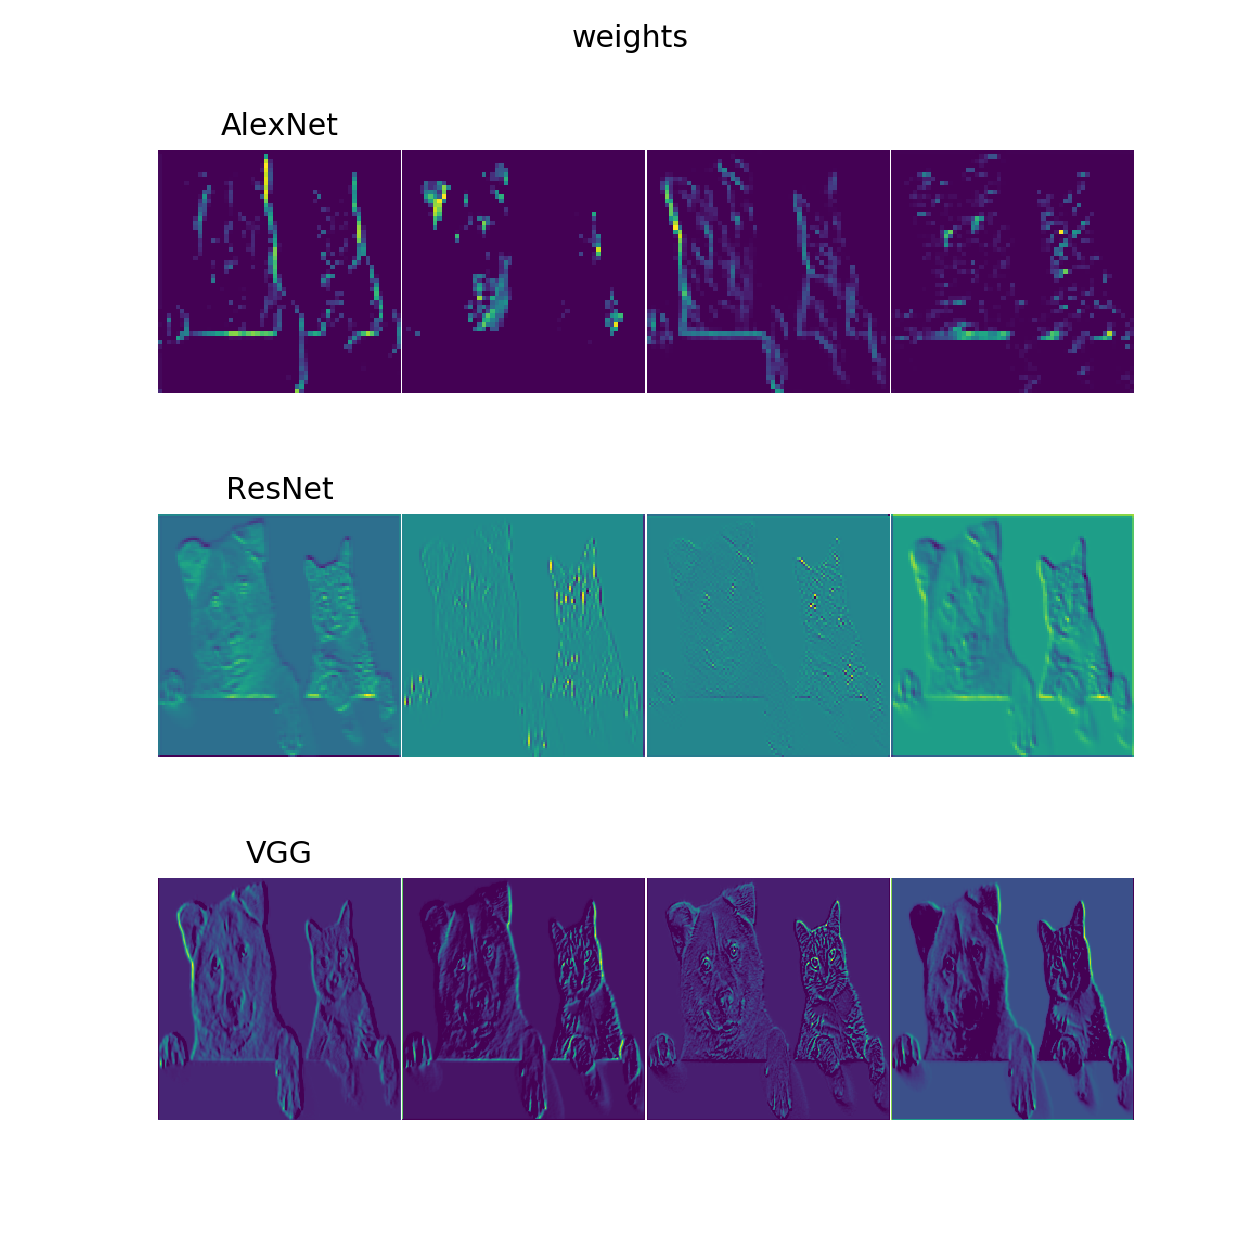

In [372]:
N_IMAGES = 4
size = (4, 1) # show 4 image per row

modules_instances = [alexnet, resnet34, vgg16]

modules = (m(pretrained=True) for m in modules_instances) # make a generator, we don't want to store in memory all of them at once

run_vis_plot_across_models(modules, inputs[0], 0, Weights , 'weights', ncols=4)


# Saliency Visualisation
One idea used by *Deep Inside Convolutional Networks/ Visualising* is to use back-propagation of the output class score with respect to the input. This will highligh the part of the image responsible for that class. Let's start with alexnet.

In [131]:
collie = {}
with open('imaganet2human.txt') as f:
    for line in f.readlines():
        key, value = line.split(':')
        key = key.replace('{', '').replace('}', '') # I forget how regex works :) 
        value = value.replace("'", '').replace(",", '')
        imagenet2human[int(key.strip())] = str(value.strip())
imagenet2human

{0: 'tench Tinca tinca',
 1: 'goldfish Carassius auratus',
 2: 'great white shark white shark man-eater man-eating shark Carcharodon carcharias',
 3: 'tiger shark Galeocerdo cuvieri',
 4: 'hammerhead hammerhead shark',
 5: 'electric ray crampfish numbfish torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich Struthio camelus',
 10: 'brambling Fringilla montifringilla',
 11: 'goldfinch Carduelis carduelis',
 12: 'house finch linnet Carpodacus mexicanus',
 13: 'junco snowbird',
 14: 'indigo bunting indigo finch indigo bird Passerina cyanea',
 15: 'robin American robin Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel dipper',
 21: 'kite',
 22: 'bald eagle American eagle Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl great gray owl Strix nebulosa',
 25: 'European fire salamander Salamandra salamandra',
 26: 'common newt Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander Ambystoma maculatum',
 29: 'axolotl mud 

Let's first print the prediction of the network (this could change if you re-run the cell)

In [145]:
pred = model(inputs[0])
_, id = torch.max(pred, 1)

print('predicted class {}'.format(imagenet2human[id.item()]))

predicted class collie


Now we can use that class inside my `SaliencyMap` map implementation. It will backpropr the outpad with respect to the one hot encoding representation of the number corresponding to `collie` in our case `231`

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


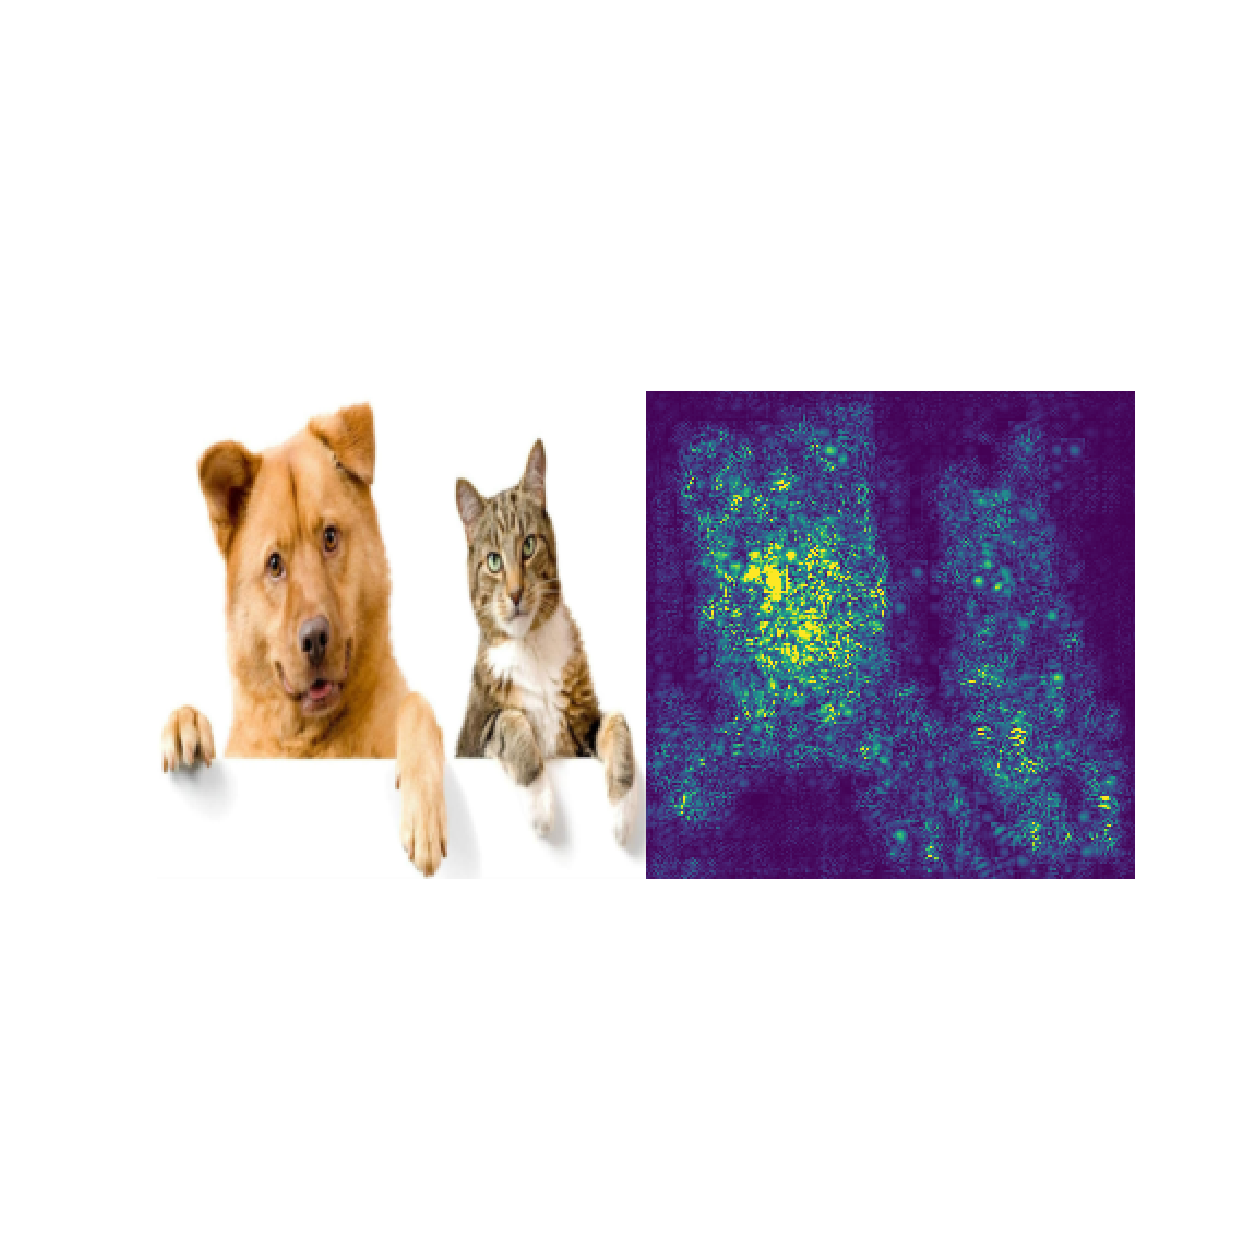

In [377]:
from visualisation.core.utils import image_net_postprocessing

vis = SaliencyMap(model, device)

out = vis(inputs[0], 
          first_layer,
          target_class=231)

subplot([image_net_postprocessing(inputs[0].squeeze()), out], 
        parse=tensor2img, 
        nrows=1, ncols=2)


We can see that `alexnet` get exited most on the dog. We can even do better! We can set to `0` each **negative** relu gradient when backprop. This is techinique is called `guided`.

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


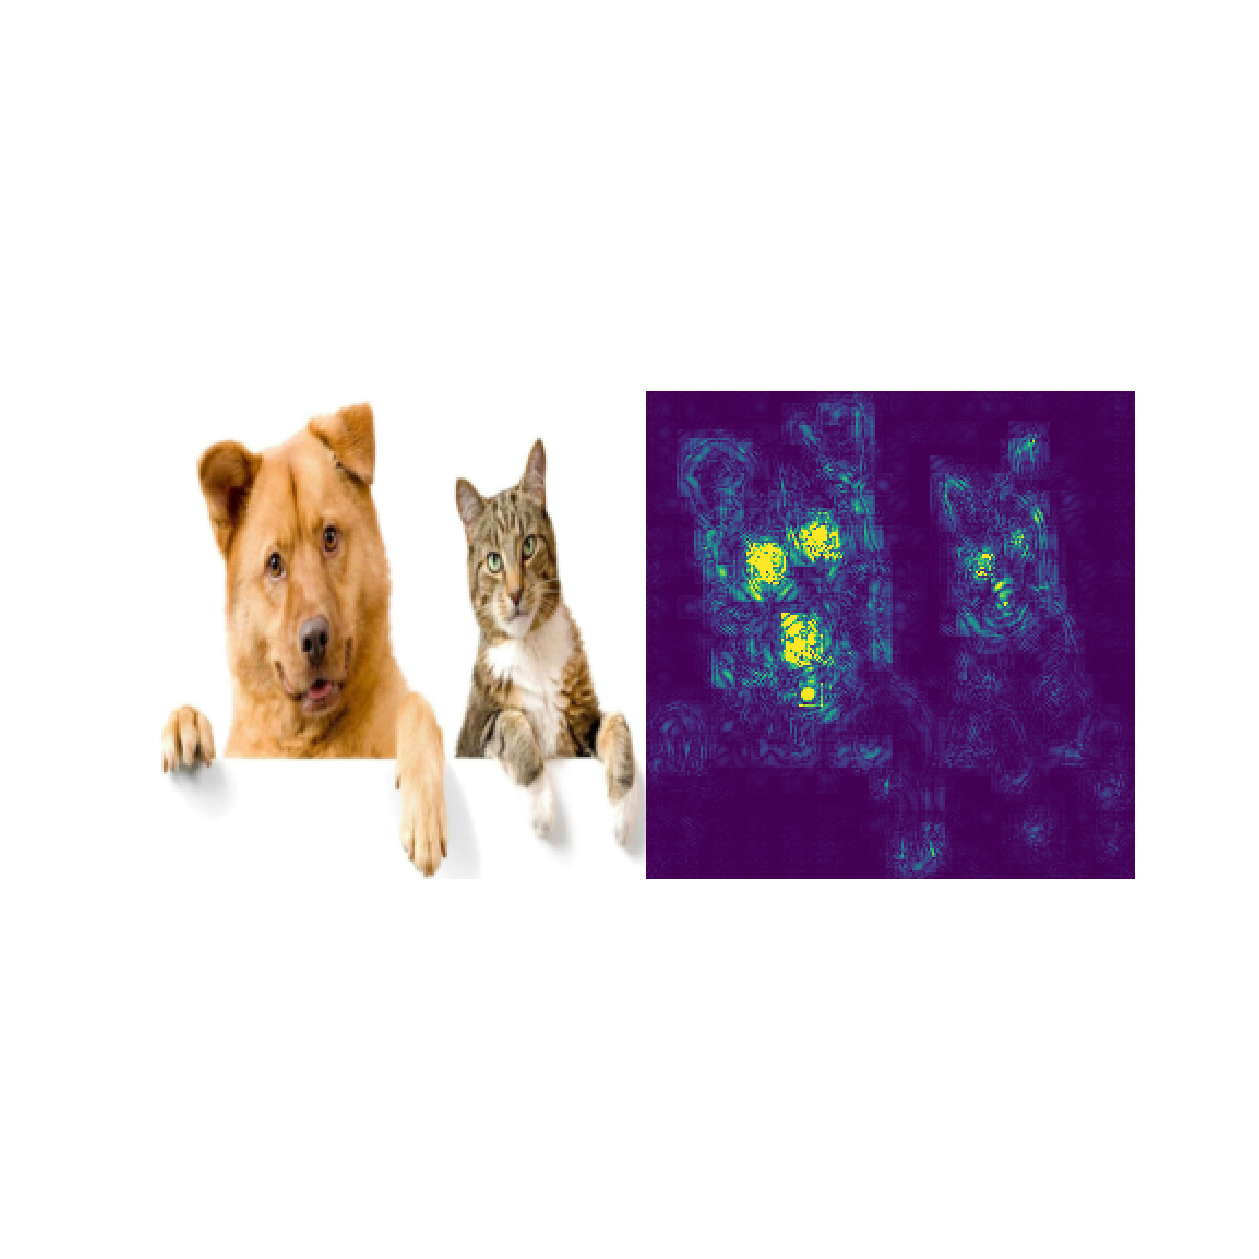

In [381]:
out = vis(inputs[0], 
          first_layer,
          guide=True,
          target_class=231)

subplot([image_net_postprocessing(inputs[0].squeeze()), out], 
        parse=tensor2img, 
        nrows=1, ncols=2)

Now we can clearly see that the network is looking at the eyes and the nose of the dog. Let's blend this two image for an even better visualisation.

In [388]:
import cv2

def blend_tensors(x, y):
    x_np, y_np = np.uint8(x.numpy().transpose(1,2,0) * 255), np.uint8(y.numpy().squeeze() * 255)
    y_np[y_np <= 100] = 0 # remove small grad
    heatmap = cv2.applyColorMap(y_np, cv2.COLORMAP_JET)
    blend = cv2.addWeighted(x_np, 0.5, heatmap, 0.3, 0)
    return blend

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


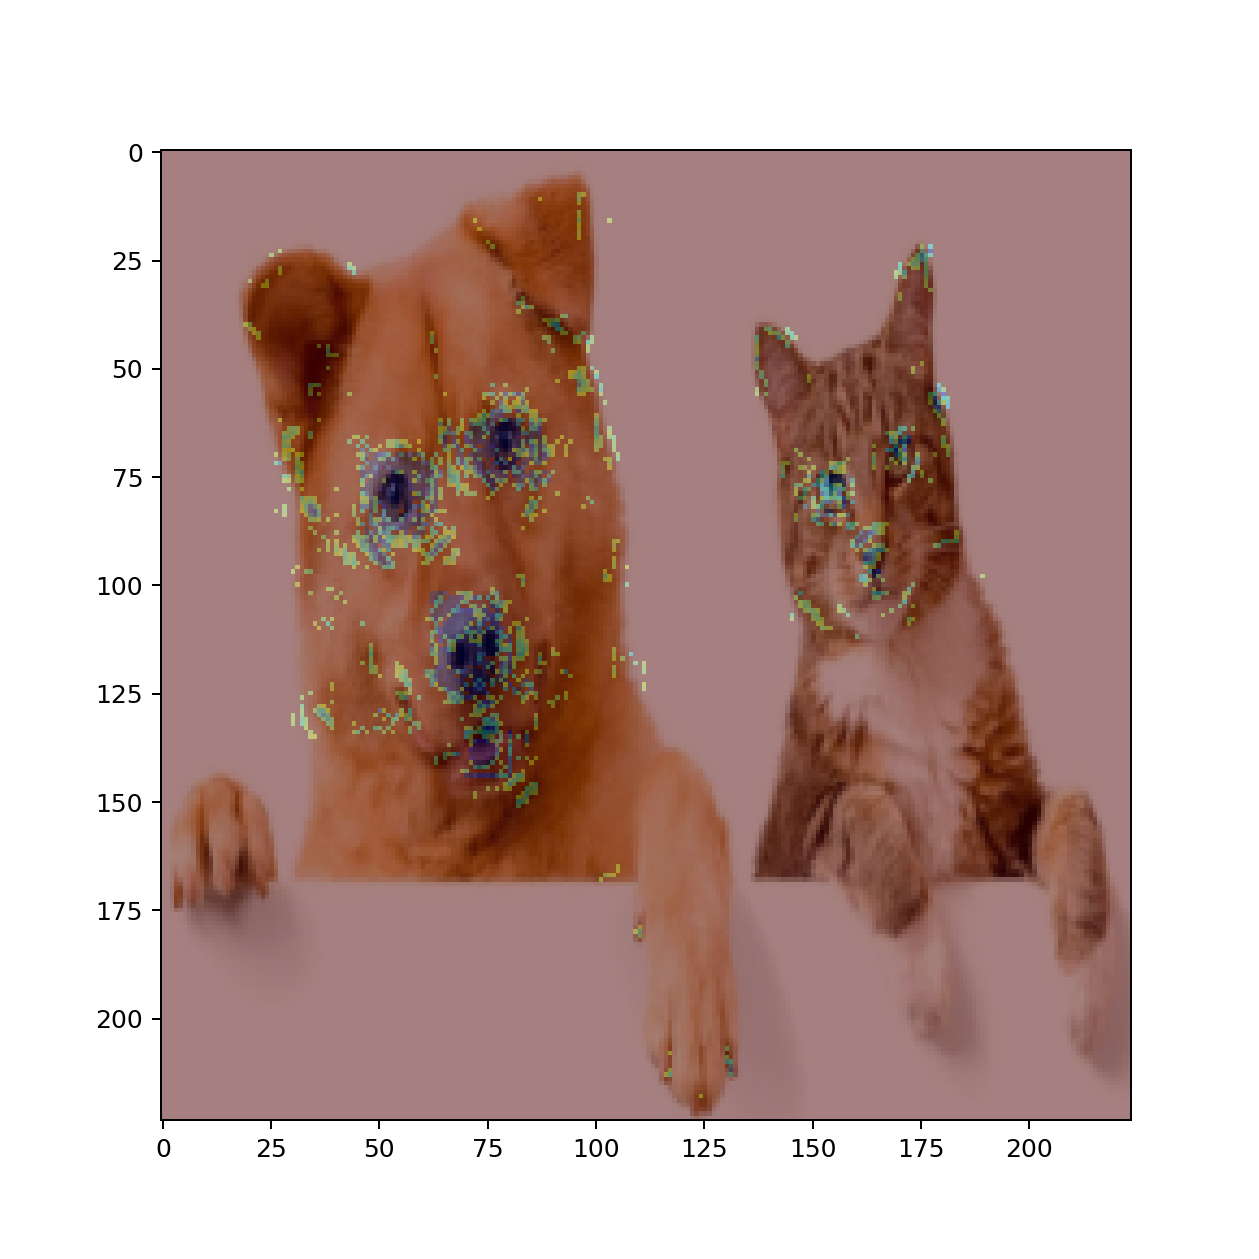

In [389]:
blend = blend_tensors(image_net_postprocessing(inputs[0].squeeze()), out.squeeze(0))
fig = plt.figure()
plt.imshow(blend)

We can try again and change the `target_class` to `cat`

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


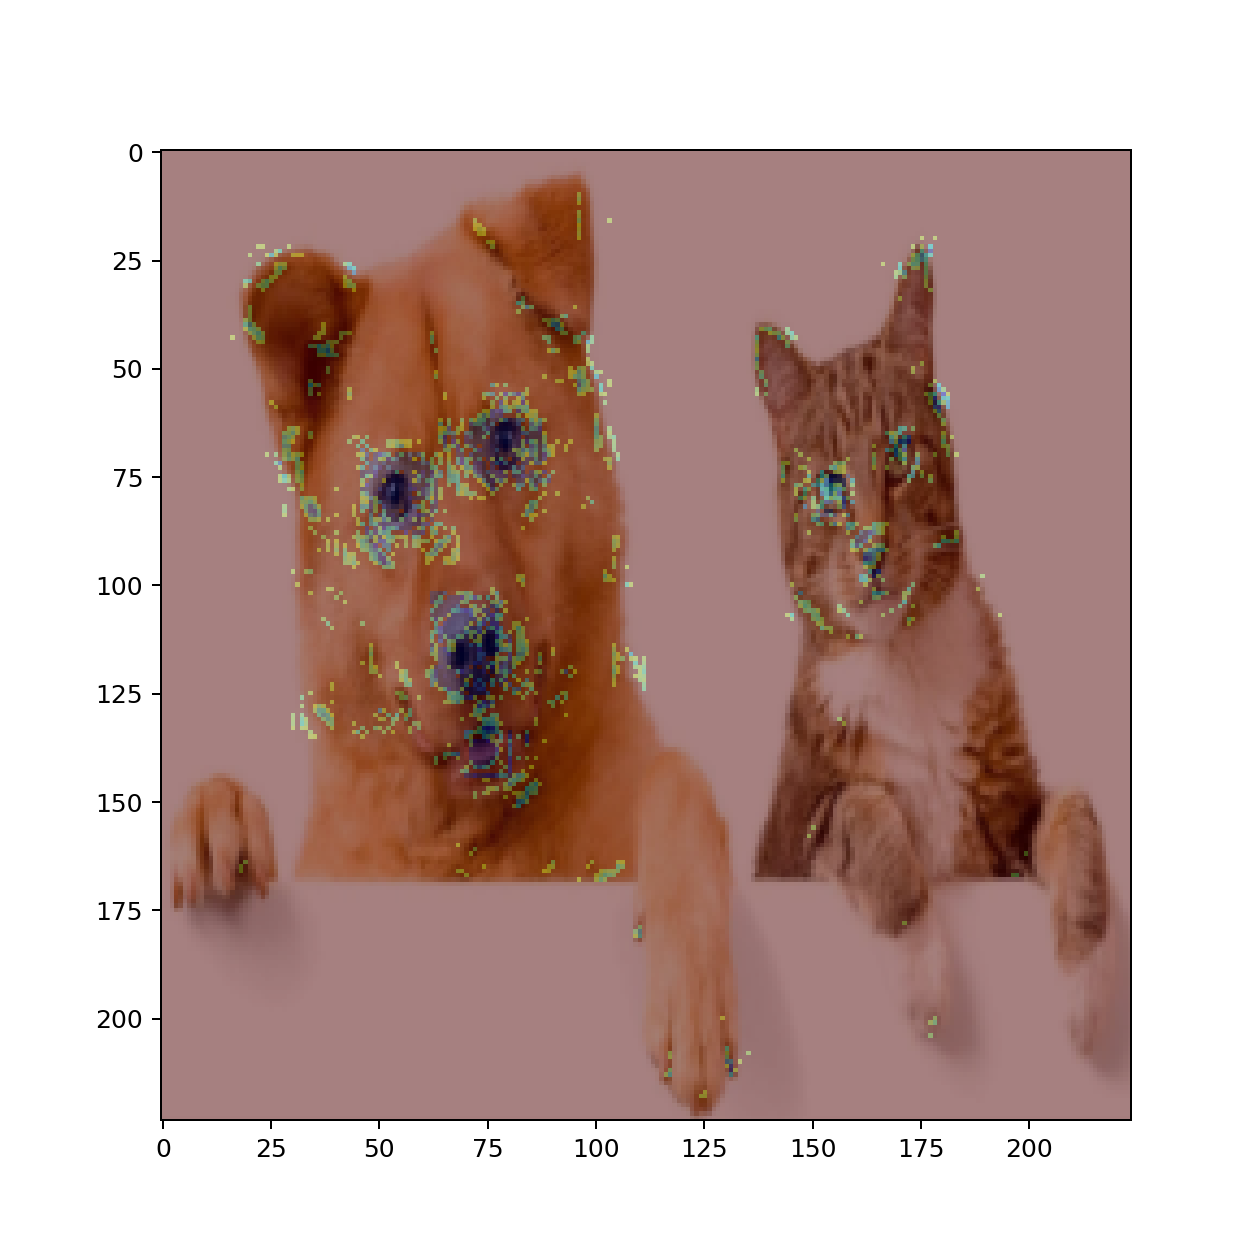

In [390]:
out = vis(inputs[0], 
          first_layer,
          guide=True,
          target_class=284)

blend = blend_tensors(image_net_postprocessing(inputs[0].squeeze()), out.squeeze(0))
fig = plt.figure()
plt.imshow(blend)

Still our `alexnet` looks a lot into the dog. Let's try if other networks' behavior is the same

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


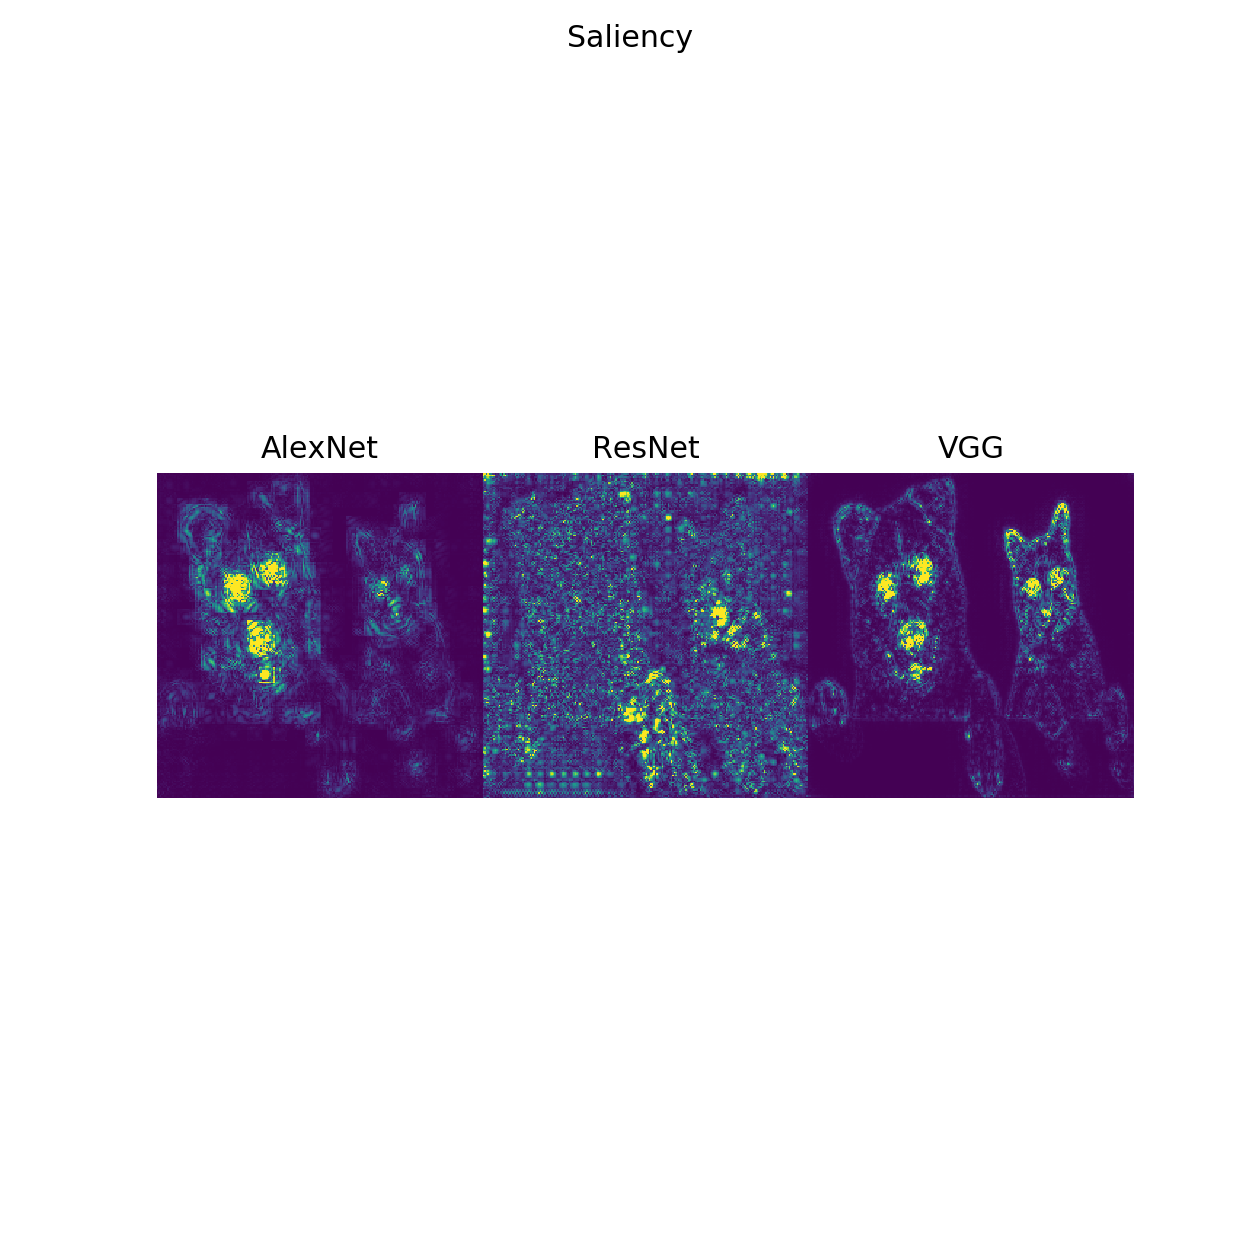

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [391]:
modules = (m(pretrained=True) for m in modules_instances) # make a generator, we don't want to store in memory all of them at once

run_vis_plot_across_models(modules, inputs[0], 0, SaliencyMap , 'Saliency', nrows=1, ncols=3, target_class=231, guide=True)


Why `Resnet` is sto screw? This is due to the residual blocks, they allows gradient to flow and therefore they screw the whole backprop. It is nice to see that in this case `alexnet` looks almost only to the dog, while `vgg` is also looking at the cat. 

While guiding yields a better human interpebable image, the vanilla implementation can be used for localizing an object of interest.